# Generating faces with Variational Autoencoders
![](http://fastforwardlabs.github.io/blog-images/miriam/imgs_code/vae.4.png)

Like the previous notebook, thegoal of this notebook was only to reproduce the results of François CHOLLET (Keras author) with VAE. 
But with a **faces dataset**

##### References 
- François CHOLLET [article](https://blog.keras.io/building-autoencoders-in-keras.html) and [repo](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)
- The excellent Otoro blog [article](http://blog.otoro.net/2017/05/19/teaching-machines-to-draw/)

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
from PIL import Image

***
# Preparing the dataset

##### Faces dataset
- http://www.face-rec.org/databases/
- https://www.kairos.com/blog/60-facial-recognition-databases
- http://www.robots.ox.ac.uk/~vgg/data/vgg_face/
- http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## Reading the images

Loading the images directly from keras python API : 

In [30]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

55600/|/[loss: 6.649]  93%|| 55600/60000 [00:20<00:00, 5762.78it/s]            

## Visualize the images

In [4]:
def plot_sample(images,n_row=8, n_col=18):
    """
    Helper function to plot a gallery of images
    """
    
    # Random selection
    selection = np.random.randint(0,len(images),n_row*n_col)
    selection = images[selection]
    
    # Plot figure
    plt.figure(figsize=(1 * n_col, 1 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(selection[i],interpolation="nearest",cmap='Greys')
        plt.xticks(())
        plt.yticks(())

##### Sample images from the dataset

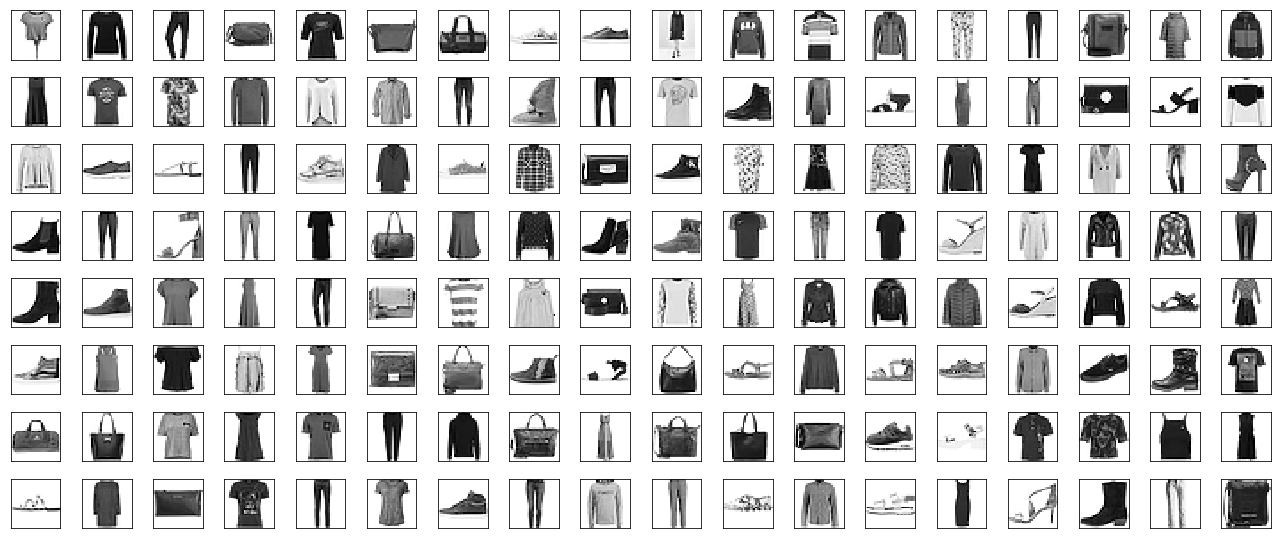

In [5]:
plot_sample(X_train)

***
# Creating a Variational Autoencoder with Keras


##### Libraries

In [51]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

##### Parameters

In [8]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

## Preprocessing the dataset
- Divide by 255
- Flatten the dataset

In [32]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

## Creating the VAE model

##### Creating the encoder

In [9]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

##### Sampling function

In [10]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

##### Creating the decoder

In [12]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

##### Custom Loss Layer

In [13]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

##### Instantiating the VAE model

In [33]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='adam', loss=None)

C:\Users\talvesdacosta\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Output "custom_variational_layer_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_4" during training.
  app.launch_new_instance()


## Train the VAE

In [53]:
from keras_tqdm import TQDMNotebookCallback
callback = TQDMNotebookCallback(leave_inner=True,leave_outer=True)

##### Training

In [37]:
vae.fit(X_train,
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(X_test, None),
        callbacks = [callback],verbose = 0)

***
# Visualizing the results

## Visualizing the latent space in 2D

In [39]:
encoder = Model(x, z_mean)

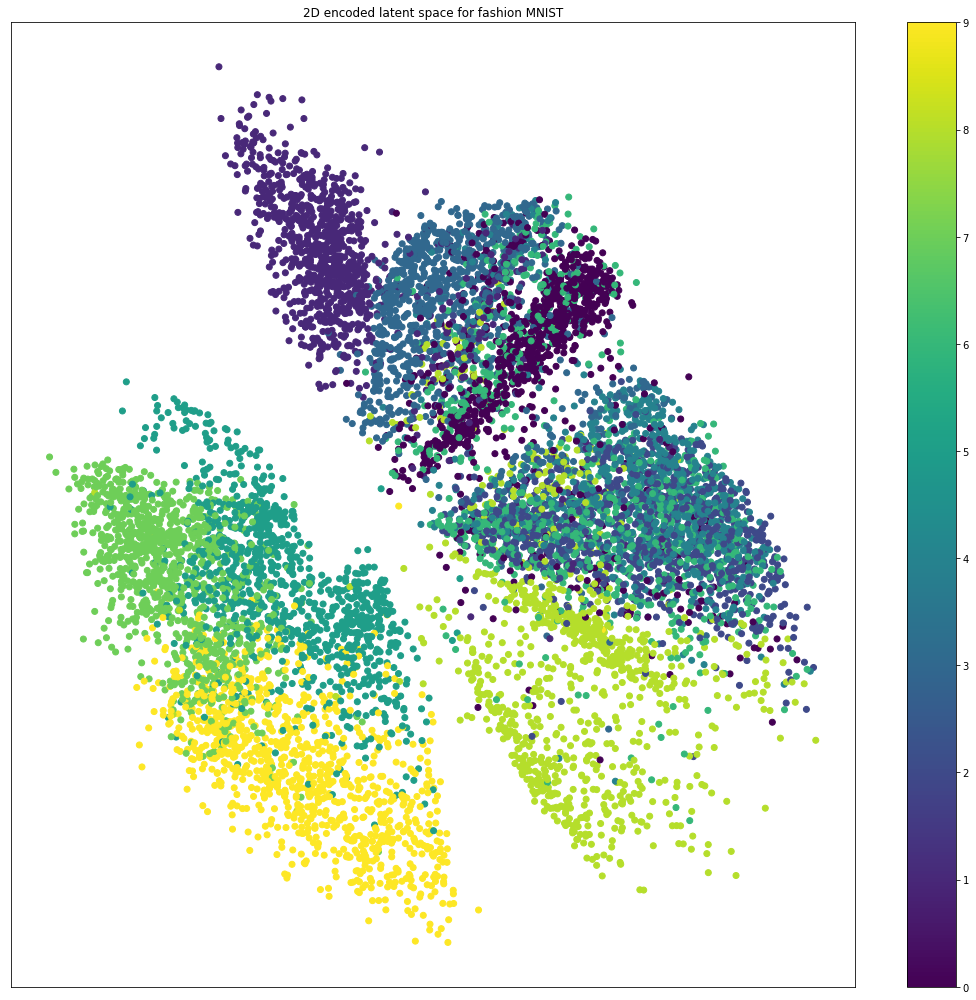

In [58]:
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(15, 14))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=y_test)
plt.title("2D encoded latent space for fashion MNIST")
plt.xticks(())
plt.yticks(())
plt.colorbar()
plt.tight_layout()
plt.show()

In [59]:
from matplotlib import offsetbox

In [71]:
X_test_encoded

array([[-1.21677327, -1.01032865],
       [ 2.19582868, -0.15580907],
       [-1.28166389,  2.68851709],
       ..., 
       [ 0.08888136,  0.98845851],
       [-0.4855361 ,  1.54197812],
       [-0.94841915, -0.53113836]], dtype=float32)

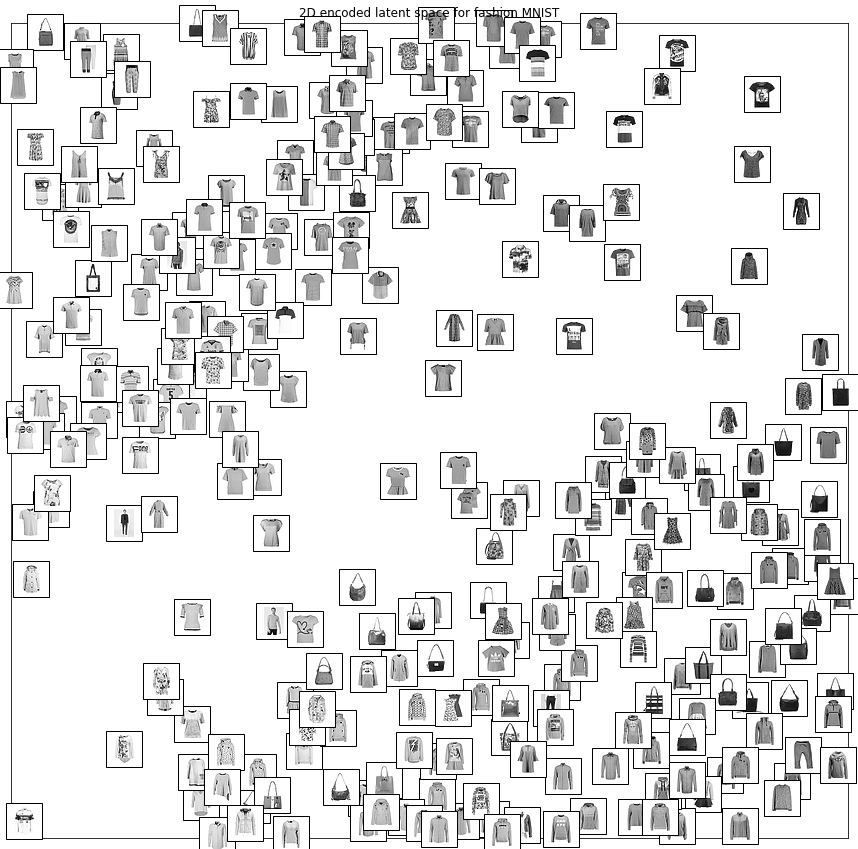

In [77]:
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
# plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=y_test)

selection = np.random.randint(0,len(X_test),10000)
X_test_encoded_selection = X_test_encoded[selection]
X_test_selection = X_test[selection]

shown_images = np.array([[100, 100]])  # just something big
for j,i in enumerate(selection):
    dist = np.sum((X_test_encoded_selection[j] - shown_images) ** 2, 1)
    if np.min(dist) < 4e-4:
        continue
    shown_images = np.r_[shown_images, [X_test_encoded_selection[j]]]
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(X_test[i].reshape((28,28)), cmap=plt.cm.gray_r),
        X_test_encoded_selection[j])
    ax.add_artist(imagebox)
    
plt.title("2D encoded latent space for fashion MNIST")
plt.xticks(())
plt.yticks(())    
plt.show()

## Visualizing the products generated on the latent space

##### Build a fashion generator that can sample from the learned distribution

In [44]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

##### Display the generated results

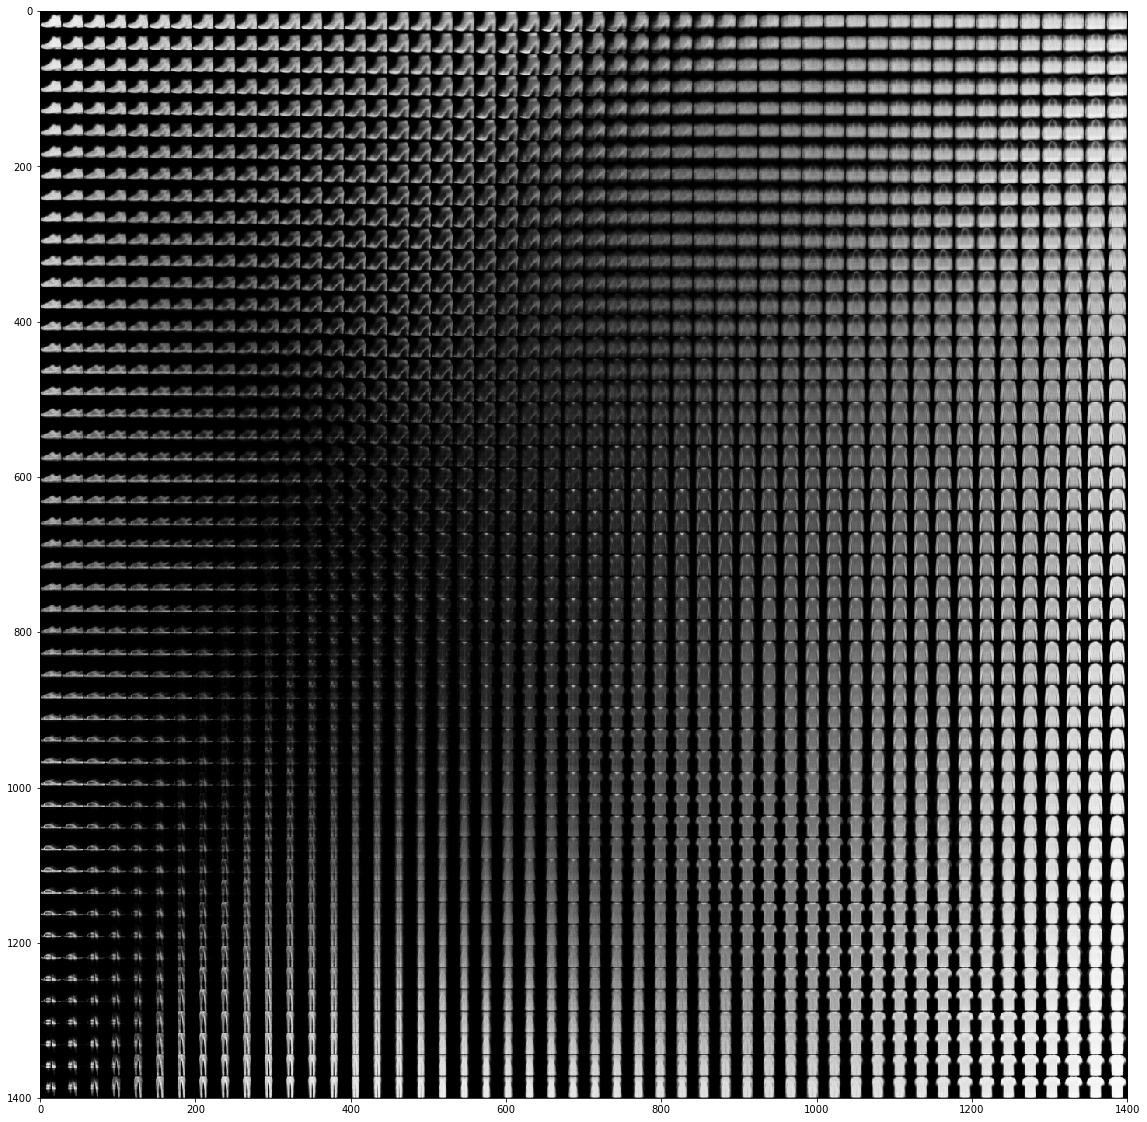

In [75]:
n = 50  
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20,20))
plt.imshow(figure, cmap='Greys_r')
plt.show()